# 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score,roc_auc_score, make_scorer


In [2]:
file_name = '/Users/limdonggeon/Desktop/SNU_FINTECH/Machine_Learning_and_Deep_Learning/Team_project_1/data/BankChurners.csv'
df = pd.read_csv(file_name)
df = df.iloc[:,1:-2]#마지막 두열 삭제
df = df.drop(['Avg_Open_To_Buy'],axis=1)

In [3]:
# # 이상치 처리
# def optimise_higher_values(n):
#     if n>=upper_limit:
#         return upper_limit
#     return n

# cols = ['Credit_Limit','Total_Trans_Amt']

# for i in cols:
#     perc_25 = df[i].quantile(.25)
#     perc_75 = df[i].quantile(.75)

#     iqr = perc_75 - perc_25

#     upper_limit = perc_75 + 1.5 * iqr
#     df[i]=df[i].apply(optimise_higher_values)

In [4]:
# Attrition_Flag 0, 1로 구분 하게 만들기
df['Attrition_Flag']=df['Attrition_Flag'].map({'Existing Customer':0,'Attrited Customer':1})
df = pd.get_dummies(df,drop_first=True)
X = df.drop('Attrition_Flag',axis=1)
y = df['Attrition_Flag']


In [5]:
# train, valid, test set으로 분리
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4,stratify=y, random_state=9)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5,stratify=y_temp,random_state=9)

In [6]:
def compute_custom_value(y_true, y_pred, X):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    # False Negative와 False Positive에 해당하는 인덱스 챶기
    fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]
    fp_indices = np.where((y_true == 0) & (y_pred == 1))[0]

    # 'Total_Trans_Amt'의 합을 계산
    fn_total_trans_amt = X.iloc[fn_indices]['Total_Trans_Amt'].sum()
    fp_total_trans_amt = X.iloc[fp_indices]['Total_Trans_Amt'].sum()

    return 0.67 * fn_total_trans_amt + 0.33 * fp_total_trans_amt


def custom_score_func(y_true, y_pred, X):
    value = compute_custom_value(y_true, y_pred, X)
    # Minimize 된 값을 찾기 위해 -value를 Maximize
    return -value


def compute_recall(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    return tp / (tp + fn)

# 평가 지표를 저장할 빈 DataFrame 생성
model_evaluation = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'Custom Value'])

# 평가 지표를 DataFrame에 추가하는 함수
def add_evaluation_metrics(model_name, accuracy, f1, precision, recall, custom_value):
    global model_evaluation
    model_evaluation = model_evaluation.append({'Model': model_name,
                                                'Accuracy': accuracy,
                                                'F1-Score': f1,
                                                'Precision': precision,
                                                'Recall': recall,
                                                'Custom Value': custom_value},
                                                ignore_index=True)


# Logistic

In [7]:
# Logistic
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for C in param_grid['C']:
        for solver in param_grid['solver']:
            logistic_classifier = LogisticRegression(C=C, solver=solver, random_state=42)
            logistic_classifier.fit(X_train_scaled, y_train)

            y_pred = logistic_classifier.predict(X_valid_scaled)

            acc = accuracy_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred)
            conf_matrix = confusion_matrix(y_valid, y_pred)
            recall = compute_recall(conf_matrix)

            evaluation_metrics.append({
                'Scaler Type': scaler_name,
                'C': C,
                'solver': solver,
                'LogisticClassifier Accuracy': acc,
                'LogisticClassifier F1-Score': f1,
                'LogisticClassifier Precision': precision,
                'LogisticClassifier Recall': recall,
                'LogisticClassifier Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                'LogisticClassifier Confusion Matrix': conf_matrix
            })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation


/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics

,Scaler Type,C,solver,LogisticClassifier Accuracy,LogisticClassifier F1-Score,LogisticClassifier Precision,LogisticClassifier Recall,LogisticClassifier Custom Value,LogisticClassifier Confusion Matrix
0,StandardScaler,0.001,newton-cg,0.857778,0.208791,0.974359,0.116923,643209.81,"[[1699, 1], [287, 38]]"
1,StandardScaler,0.001,lbfgs,0.857778,0.208791,0.974359,0.116923,643209.81,"[[1699, 1], [287, 38]]"
2,StandardScaler,0.001,liblinear,0.894321,0.586873,0.787565,0.467692,500263.33,"[[1659, 41], [173, 152]]"
3,StandardScaler,0.001,sag,0.857778,0.208791,0.974359,0.116923,643209.81,"[[1699, 1], [287, 38]]"
4,StandardScaler,0.001,saga,0.857778,0.208791,0.974359,0.116923,643209.81,"[[1699, 1], [287, 38]]"
5,StandardScaler,0.010,newton-cg,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
6,StandardScaler,0.010,lbfgs,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
7,StandardScaler,0.010,liblinear,0.898272,0.615672,0.781991,0.507692,469540.97,"[[1654, 46], [160, 165]]"
8,StandardScaler,0.010,sag,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
9,StandardScaler,0.010,saga,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
C: 10.0
solver: newton-cg
------------------------------


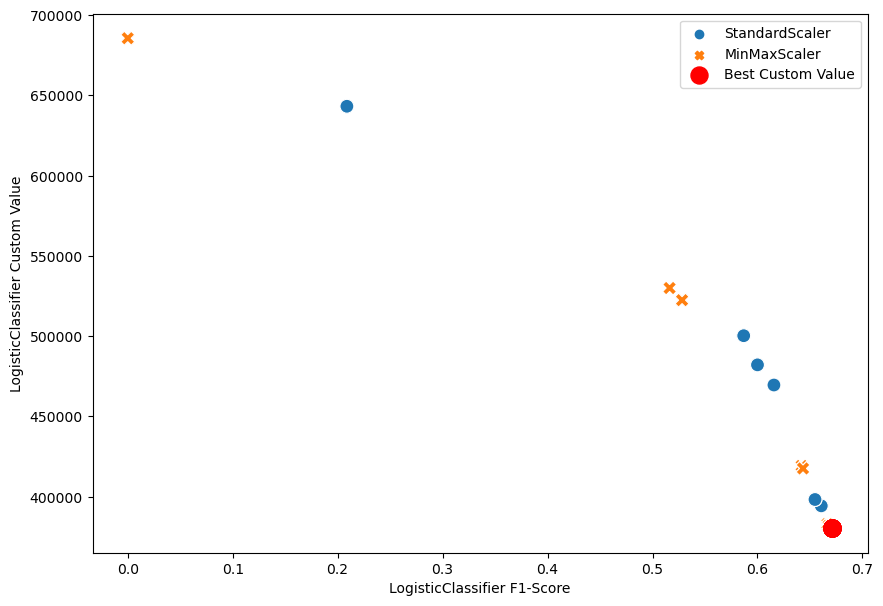

In [8]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='LogisticClassifier F1-Score', y='LogisticClassifier Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

# best hyperparameter 선정
best_custom_value_row = df_evaluation[df_evaluation['LogisticClassifier Custom Value'] == df_evaluation['LogisticClassifier Custom Value'].min()]
plt.scatter(best_custom_value_row['LogisticClassifier F1-Score'], best_custom_value_row['LogisticClassifier Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"C: {best_custom_value_row['C'].iloc[0]}")
print(f"solver: {best_custom_value_row['solver'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()

Best Scaler Type: StandardScaler

Best hyperparameters:
C: 10.0
solver: newton-cg

Best Set Accuracy: 0.9062
Best Set F1-Score: 0.6713
Best Set Precision: 0.7668
Best Set Recall: 0.5969
Best Set Custom Value: 380317.3700


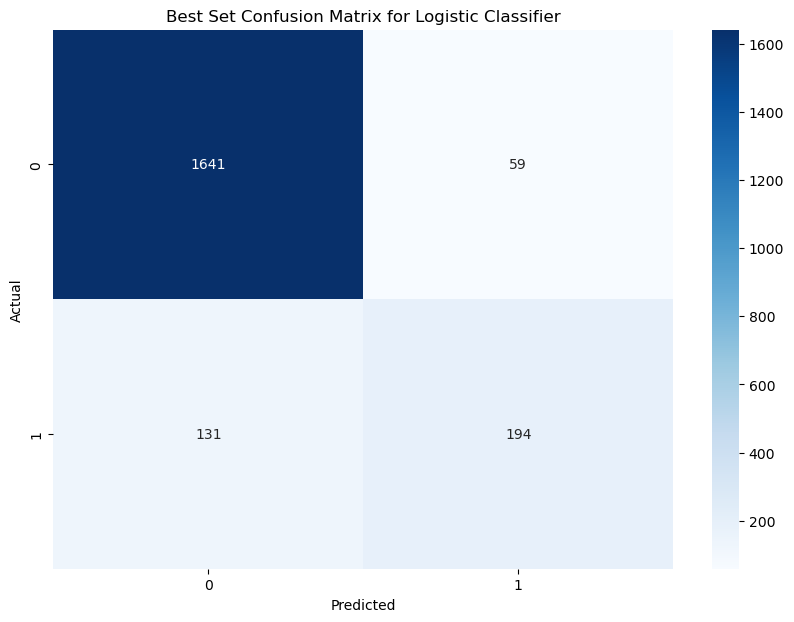

In [9]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_C = best_custom_value_row['C'].iloc[0]
best_solver = best_custom_value_row['solver'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"C: {best_C}")
print(f"solver: {best_solver}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_logistic = LogisticRegression(C=best_C, solver=best_solver, random_state=42)
best_logistic.fit(X_train_scaled_best, y_train)

y_valid_pred = best_logistic.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix for Logistic Classifier')
plt.show()


Test Set Accuracy: 0.9112
Test Set F1-Score: 0.6980
Test Set Precision: 0.7704
Test Set Recall: 0.6380
Test Set Custom Value: 359026.3100


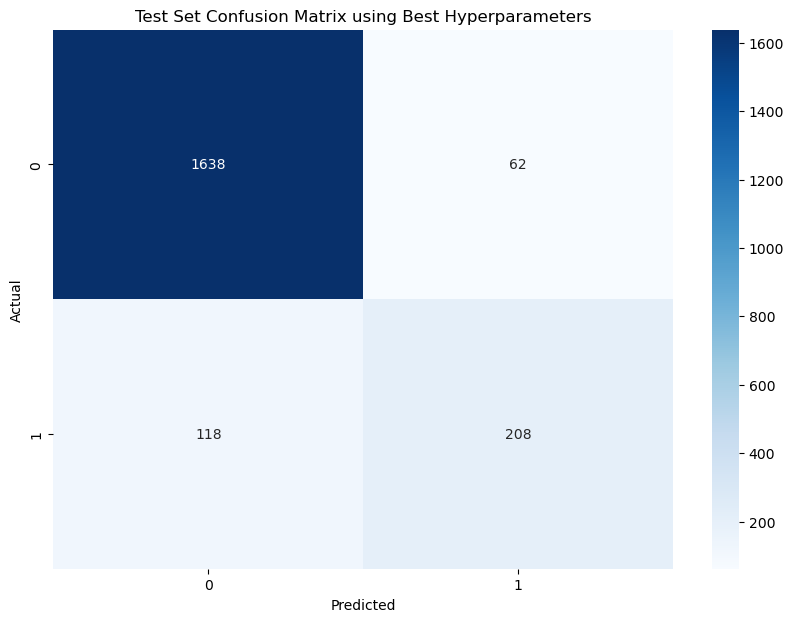

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987    0.77037  0.638037     359026.31


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [10]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_logistic.predict(X_test_scaled)

# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

# 비교를 위해 평가 추가
add_evaluation_metrics('LogisticClassifier', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)


# Lasso

In [11]:
# Logistic - penatly : l1 (Lasso)
param_grid = {
    'C': [ 0.1,0.2,0.3,0.4, 0.5,0.6,0.7,0.8,0.9, 1,10]
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for C in param_grid['C']:
        lasso_classifier = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
        lasso_classifier.fit(X_train_scaled, y_train)

        y_pred = lasso_classifier.predict(X_valid_scaled)

        acc = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        precision = precision_score(y_valid, y_pred)
        conf_matrix = confusion_matrix(y_valid, y_pred)
        recall = compute_recall(conf_matrix)

        evaluation_metrics.append({
            'Scaler Type': scaler_name,
            'C': C,
            'LassoClassifier Accuracy': acc,
            'LassoClassifier F1-Score': f1,
            'LassoClassifier Precision': precision,
            'LassoClassifier Recall': recall,
            'LassoClassifier Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
            'LassoClassifier Confusion Matrix': conf_matrix
        })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation


,Scaler Type,C,LassoClassifier Accuracy,LassoClassifier F1-Score,LassoClassifier Precision,LassoClassifier Recall,LassoClassifier Custom Value,LassoClassifier Confusion Matrix
0,StandardScaler,0.1,0.904691,0.657194,0.777311,0.569231,404924.51,"[[1647, 53], [140, 185]]"
1,StandardScaler,0.2,0.905185,0.661972,0.773663,0.578462,396661.46,"[[1645, 55], [137, 188]]"
2,StandardScaler,0.3,0.905679,0.666667,0.770161,0.587692,390391.94,"[[1643, 57], [134, 191]]"
3,StandardScaler,0.4,0.905185,0.664336,0.769231,0.584615,391625.41,"[[1643, 57], [135, 190]]"
4,StandardScaler,0.5,0.905679,0.666667,0.770161,0.587692,385943.81,"[[1643, 57], [134, 191]]"
5,StandardScaler,0.6,0.905679,0.666667,0.770161,0.587692,385943.81,"[[1643, 57], [134, 191]]"
6,StandardScaler,0.7,0.905185,0.665505,0.767068,0.587692,390227.21,"[[1642, 58], [134, 191]]"
7,StandardScaler,0.8,0.904691,0.663176,0.766129,0.584615,391886.13,"[[1642, 58], [135, 190]]"
8,StandardScaler,0.9,0.905185,0.665505,0.767068,0.587692,388156.24,"[[1642, 58], [134, 191]]"
9,StandardScaler,1.0,0.905679,0.667826,0.768000,0.590769,383023.37,"[[1642, 58], [133, 192]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
C: 10.0
------------------------------


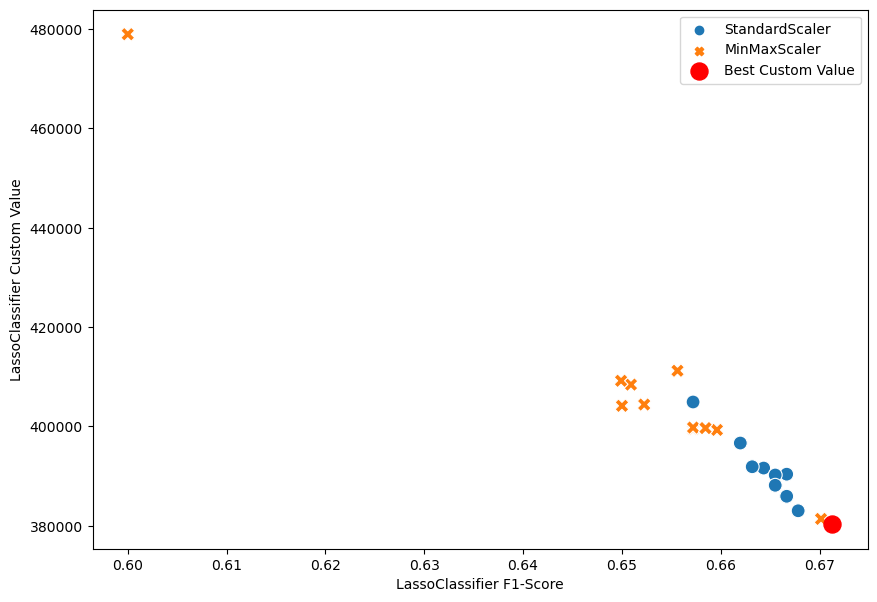

In [12]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='LassoClassifier F1-Score', y='LassoClassifier Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

# best hyperparameter 선정
best_custom_value_row = df_evaluation[df_evaluation['LassoClassifier Custom Value'] == df_evaluation['LassoClassifier Custom Value'].min()]
plt.scatter(best_custom_value_row['LassoClassifier F1-Score'], best_custom_value_row['LassoClassifier Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"C: {best_custom_value_row['C'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()

Best Scaler Type: StandardScaler

Best hyperparameters:
C: 10.0

Best Set Accuracy: 0.9062
Best Set F1-Score: 0.6713
Best Set Precision: 0.7668
Best Set Recall: 0.5969
Best Set Custom Value: 380317.3700


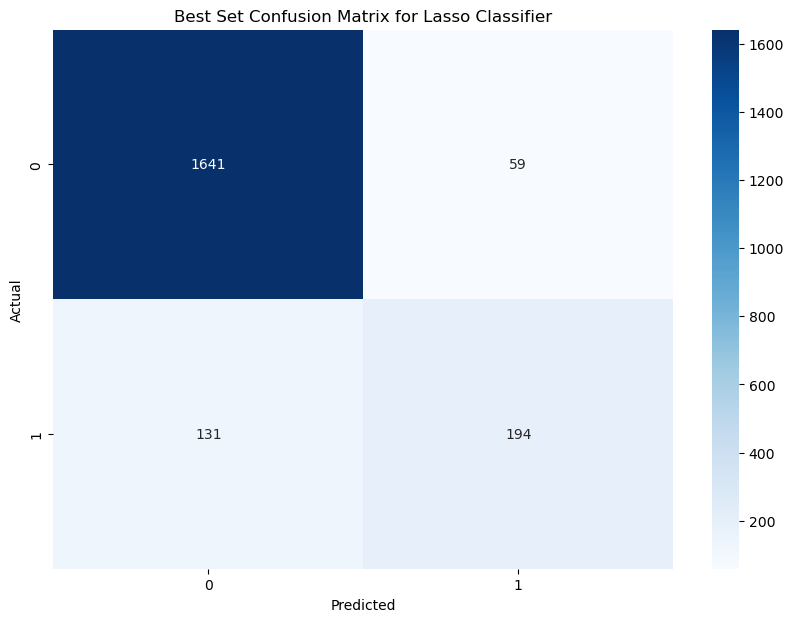

In [13]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_C = best_custom_value_row['C'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"C: {best_C}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_lasso = LogisticRegression(penalty='l1', C=best_C, solver='liblinear', random_state=42)
best_lasso.fit(X_train_scaled_best, y_train)

y_valid_pred = best_lasso.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix for Lasso Classifier')
plt.show()


Test Set Accuracy: 0.9112
Test Set F1-Score: 0.6980
Test Set Precision: 0.7704
Test Set Recall: 0.6380
Test Set Custom Value: 359026.3100


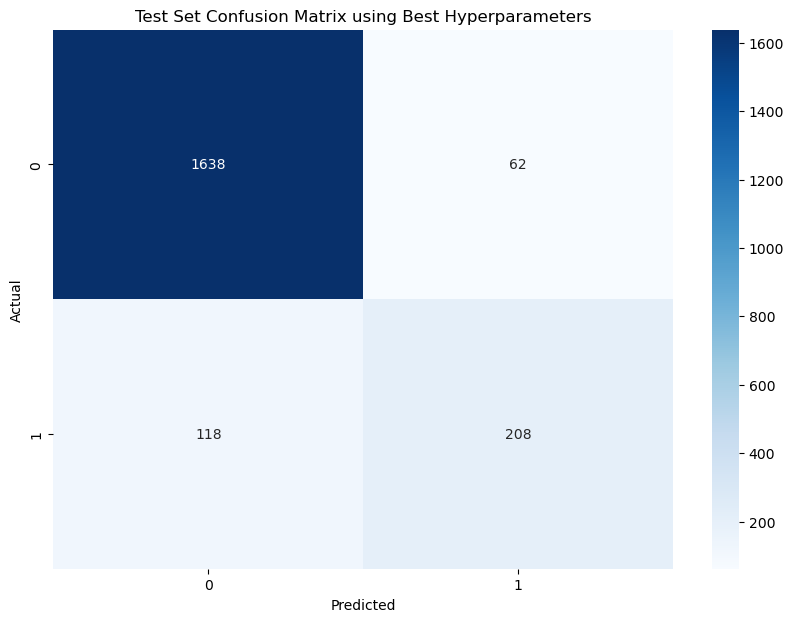

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987    0.77037  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987    0.77037  0.638037     359026.31


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [14]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_lasso.predict(X_test_scaled)

# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")


plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

# 비교를 위해 평가 추가
add_evaluation_metrics('LassoClassifier', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)


# Ridge

In [15]:
# Logistic penalty : l2 (Ridge)
param_grid = {
    'C': [ 0.01, 0.1, 1,2,3,4,5,6,7,8,9, 10,],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for C in param_grid['C']:
        for solver in param_grid['solver']:
            logistic_classifier = LogisticRegression(C=C, solver=solver, random_state=42)
            logistic_classifier.fit(X_train_scaled, y_train)

            y_pred = logistic_classifier.predict(X_valid_scaled)

            acc = accuracy_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred)
            conf_matrix = confusion_matrix(y_valid, y_pred)
            recall = compute_recall(conf_matrix)

            evaluation_metrics.append({
                'Scaler Type': scaler_name,
                'C': C,
                'solver': solver,
                'LogisticClassifier Accuracy': acc,
                'LogisticClassifier F1-Score': f1,
                'LogisticClassifier Precision': precision,
                'LogisticClassifier Recall': recall,
                'LogisticClassifier Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                'LogisticClassifier Confusion Matrix': conf_matrix
            })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation


/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/limdonggeon/anaconda3/lib/python3.10/site-packages/sklearn/metrics

,Scaler Type,C,solver,LogisticClassifier Accuracy,LogisticClassifier F1-Score,LogisticClassifier Precision,LogisticClassifier Recall,LogisticClassifier Custom Value,LogisticClassifier Confusion Matrix
0,StandardScaler,0.01,newton-cg,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
1,StandardScaler,0.01,lbfgs,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
2,StandardScaler,0.01,liblinear,0.898272,0.615672,0.781991,0.507692,469540.97,"[[1654, 46], [160, 165]]"
3,StandardScaler,0.01,sag,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
4,StandardScaler,0.01,saga,0.899259,0.600000,0.827027,0.470769,482096.43,"[[1668, 32], [172, 153]]"
...,...,...,...,...,...,...,...,...,...
115,MinMaxScaler,10.00,newton-cg,0.906173,0.667832,0.773279,0.587692,381849.44,"[[1644, 56], [134, 191]]"
116,MinMaxScaler,10.00,lbfgs,0.906173,0.667832,0.773279,0.587692,381849.44,"[[1644, 56], [134, 191]]"
117,MinMaxScaler,10.00,liblinear,0.906173,0.666667,0.775510,0.584615,382871.79,"[[1645, 55], [135, 190]]"
118,MinMaxScaler,10.00,sag,0.906173,0.667832,0.773279,0.587692,381849.44,"[[1644, 56], [134, 191]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
C: 5.0
solver: saga
------------------------------


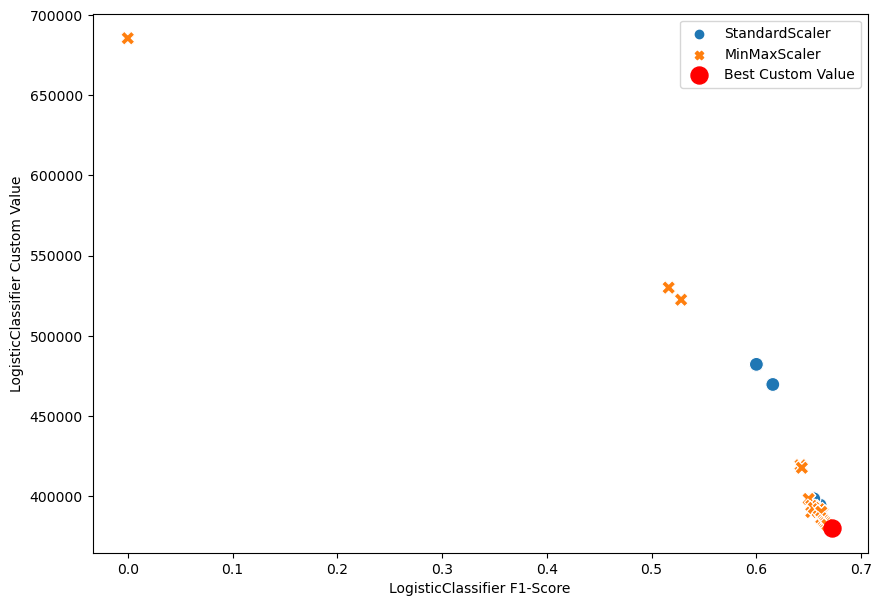

In [16]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='LogisticClassifier F1-Score', y='LogisticClassifier Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['LogisticClassifier Custom Value'] == df_evaluation['LogisticClassifier Custom Value'].min()]
plt.scatter(best_custom_value_row['LogisticClassifier F1-Score'], best_custom_value_row['LogisticClassifier Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"C: {best_custom_value_row['C'].iloc[0]}")
print(f"solver: {best_custom_value_row['solver'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()


Best Scaler Type: StandardScaler

Best hyperparameters:
C: 5.0
solver: saga

Best Set Accuracy: 0.9067
Best Set F1-Score: 0.6724
Best Set Precision: 0.7698
Best Set Recall: 0.5969
Best Set Custom Value: 379839.5300


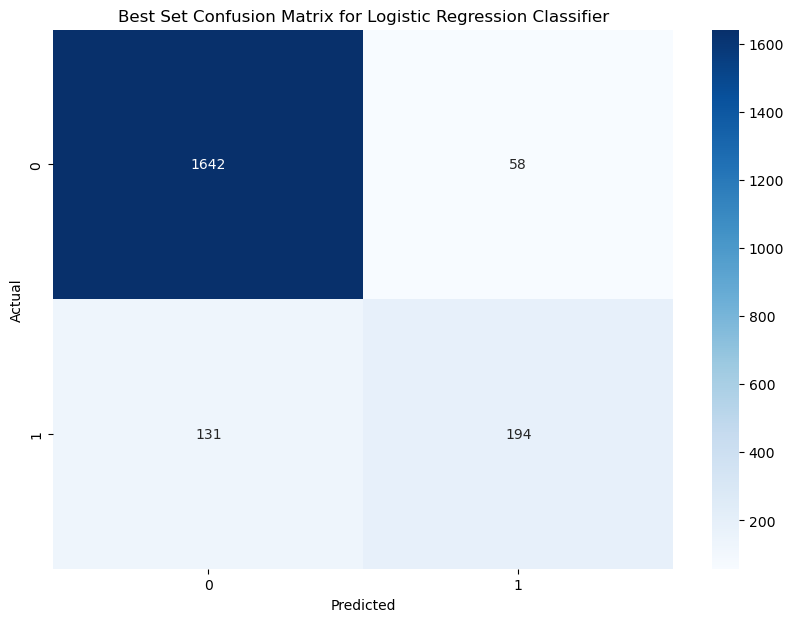

In [17]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_C = best_custom_value_row['C'].iloc[0]
best_solver = best_custom_value_row['solver'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"C: {best_C}")
print(f"solver: {best_solver}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_logistic = LogisticRegression(C=best_C, solver=best_solver, random_state=42)
best_logistic.fit(X_train_scaled_best, y_train)

y_valid_pred = best_logistic.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix for Logistic Regression Classifier')
plt.show()



Test Set Accuracy: 0.9116
Test Set F1-Score: 0.6992
Test Set Precision: 0.7732
Test Set Recall: 0.6380
Test Set Custom Value: 358539.2300


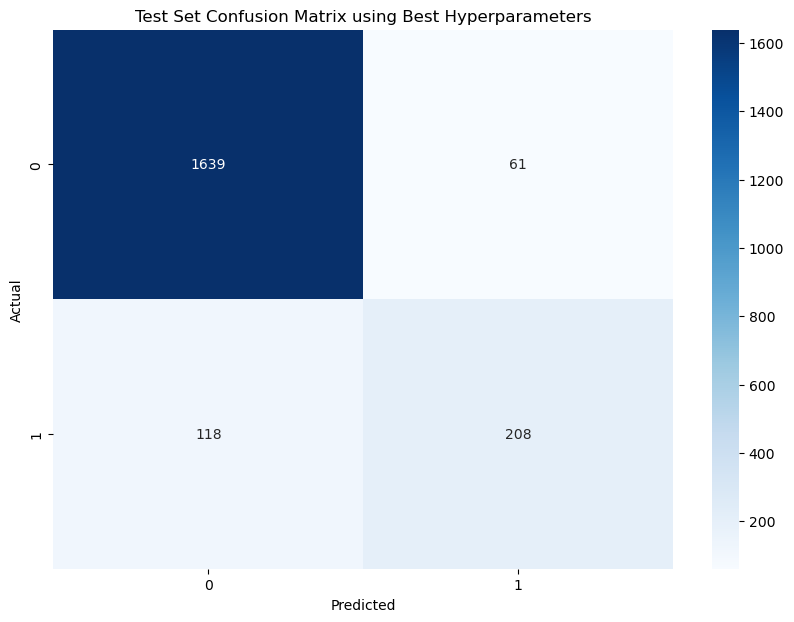

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [18]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_logistic.predict(X_test_scaled)

# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

# 비교를 위해 평가 추가
add_evaluation_metrics('LogisticClassifier', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)

# ElasticNet

In [19]:
# Logistic penalty : l1 + l2 (ElasticNet)
param_grid = {
    'C': [ 0.1, 1,2,3,4,5,6,7,8,9, 10, 100],
    'l1_ratio': [0.15, 0.3, 0.5, 0.7, 0.85]
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for C in param_grid['C']:
        for l1_ratio in param_grid['l1_ratio']:
            logistic_elastic = LogisticRegression(C=C, penalty='elasticnet', l1_ratio=l1_ratio, solver='saga', random_state=42)
            logistic_elastic.fit(X_train_scaled, y_train)

            y_pred = logistic_elastic.predict(X_valid_scaled)

            acc = accuracy_score(y_valid, y_pred)
            f1 = f1_score(y_valid, y_pred)
            precision = precision_score(y_valid, y_pred)
            conf_matrix = confusion_matrix(y_valid, y_pred)
            recall = compute_recall(conf_matrix)

            evaluation_metrics.append({
                'Scaler Type': scaler_name,
                'C': C,
                'l1_ratio': l1_ratio,
                'ElasticNetLogistic Accuracy': acc,
                'ElasticNetLogistic F1-Score': f1,
                'ElasticNetLogistic Precision': precision,
                'ElasticNetLogistic Recall': recall,
                'ElasticNetLogistic Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                'ElasticNetLogistic Confusion Matrix': conf_matrix
            })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation


,Scaler Type,C,l1_ratio,ElasticNetLogistic Accuracy,ElasticNetLogistic F1-Score,ElasticNetLogistic Precision,ElasticNetLogistic Recall,ElasticNetLogistic Custom Value,ElasticNetLogistic Confusion Matrix
0,StandardScaler,0.1,0.15,0.905679,0.660746,0.781513,0.572308,394741.53,"[[1648, 52], [139, 186]]"
1,StandardScaler,0.1,0.30,0.907160,0.665480,0.789030,0.575385,392015.80,"[[1650, 50], [138, 187]]"
2,StandardScaler,0.1,0.50,0.905185,0.657143,0.782979,0.566154,406215.75,"[[1649, 51], [141, 184]]"
3,StandardScaler,0.1,0.70,0.905185,0.658363,0.780591,0.569231,404629.82,"[[1648, 52], [140, 185]]"
4,StandardScaler,0.1,0.85,0.905185,0.658363,0.780591,0.569231,404629.82,"[[1648, 52], [140, 185]]"
...,...,...,...,...,...,...,...,...,...
115,MinMaxScaler,100.0,0.15,0.906173,0.670139,0.768924,0.593846,381389.24,"[[1642, 58], [132, 193]]"
116,MinMaxScaler,100.0,0.30,0.906173,0.670139,0.768924,0.593846,381389.24,"[[1642, 58], [132, 193]]"
117,MinMaxScaler,100.0,0.50,0.905679,0.668977,0.765873,0.593846,381867.08,"[[1641, 59], [132, 193]]"
118,MinMaxScaler,100.0,0.70,0.905679,0.668977,0.765873,0.593846,381867.08,"[[1641, 59], [132, 193]]"


Best Custom Value Hyperparameters:
Scaler: MinMaxScaler
C: 5.0
l1_ratio: 0.7
------------------------------


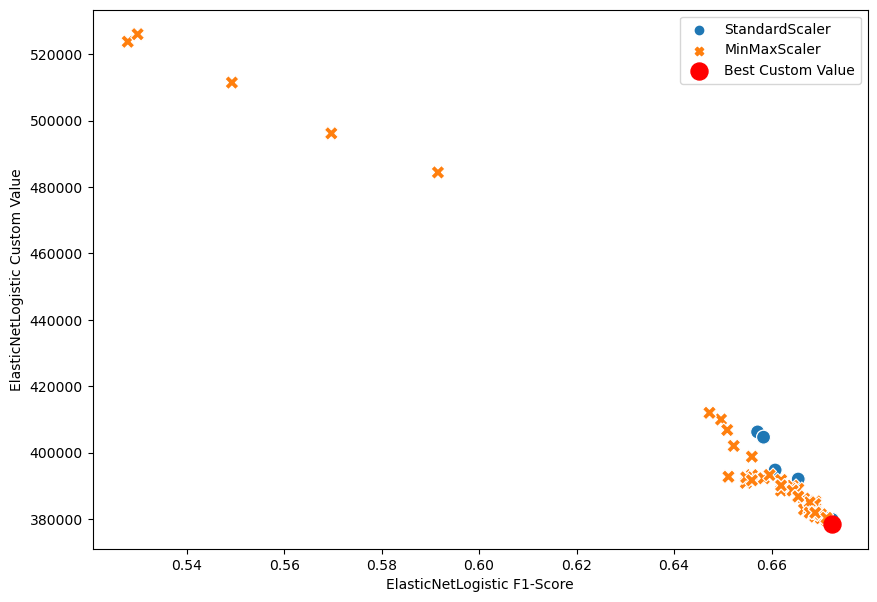

In [20]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='ElasticNetLogistic F1-Score', y='ElasticNetLogistic Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['ElasticNetLogistic Custom Value'] == df_evaluation['ElasticNetLogistic Custom Value'].min()]
plt.scatter(best_custom_value_row['ElasticNetLogistic F1-Score'], best_custom_value_row['ElasticNetLogistic Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"C: {best_custom_value_row['C'].iloc[0]}")
print(f"l1_ratio: {best_custom_value_row['l1_ratio'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()

Best Scaler Type: MinMaxScaler

Best hyperparameters:
C: 5.0
l1_ratio: 0.7

Best Set Accuracy: 0.9072
Best Set F1-Score: 0.6725
Best Set Precision: 0.7751
Best Set Recall: 0.5938
Best Set Custom Value: 378402.2200


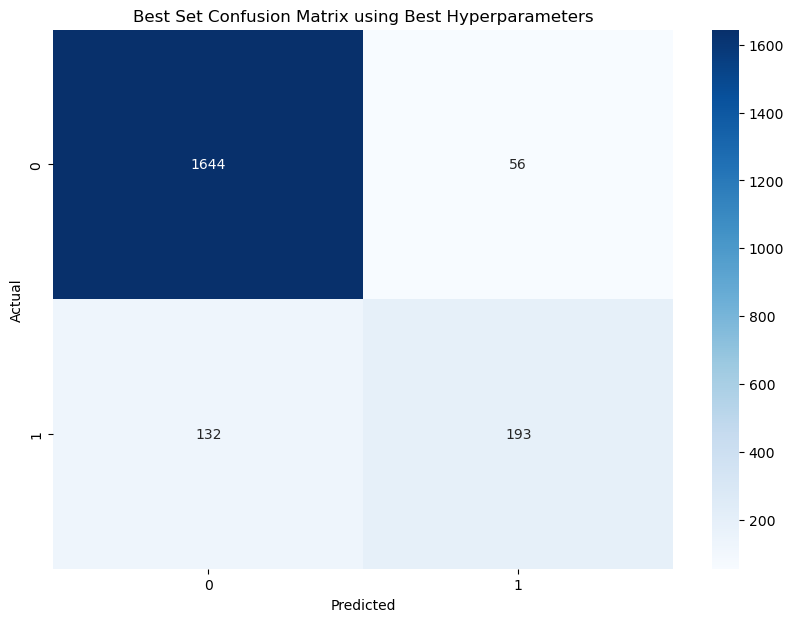

In [21]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_C = best_custom_value_row['C'].iloc[0]
best_l1_ratio = best_custom_value_row['l1_ratio'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"C: {best_C}")
print(f"l1_ratio: {best_l1_ratio}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_logistic_elastic = LogisticRegression(C=best_C, penalty='elasticnet', l1_ratio=best_l1_ratio, solver='saga', random_state=42)
best_logistic_elastic.fit(X_train_scaled_best, y_train)

y_valid_pred = best_logistic_elastic.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix using Best Hyperparameters')
plt.show()



Test Set Accuracy: 0.9107
Test Set F1-Score: 0.6937
Test Set Precision: 0.7736
Test Set Recall: 0.6288
Test Set Custom Value: 367103.1100


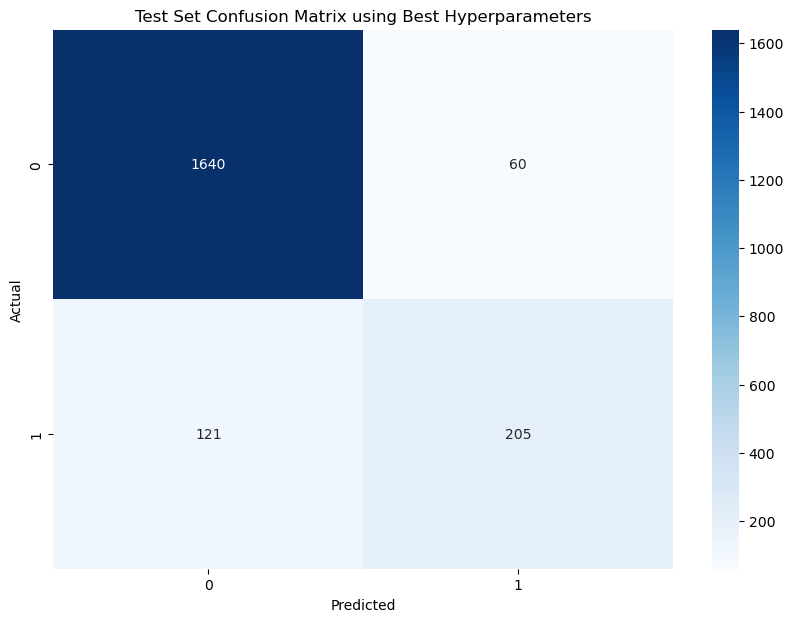

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [22]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_logistic_elastic.predict(X_test_scaled)

# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

# 비교를 위해 평가 추가
add_evaluation_metrics('ElasticNetLogistic', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)

# SVM

In [23]:
# SVM
param_grid = {
    'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 10, 100],
    'kernel': ['linear']
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for C in param_grid['C']:
        svm = SVC(C=C, kernel='linear', random_state=42)
        svm.fit(X_train_scaled, y_train)

        y_pred = svm.predict(X_valid_scaled)

        acc = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        precision = precision_score(y_valid, y_pred)
        conf_matrix = confusion_matrix(y_valid, y_pred)
        recall = compute_recall(conf_matrix)

        evaluation_metrics.append({
            'Scaler Type': scaler_name,
            'C': C,
            'SVM Accuracy': acc,
            'SVM F1-Score': f1,
            'SVM Precision': precision,
            'SVM Recall': recall,
            'SVM Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
            'SVM Confusion Matrix': conf_matrix
        })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation

,Scaler Type,C,SVM Accuracy,SVM F1-Score,SVM Precision,SVM Recall,SVM Custom Value,SVM Confusion Matrix
0,StandardScaler,0.1,0.907654,0.664273,0.797414,0.569231,398043.82,"[[1653, 47], [140, 185]]"
1,StandardScaler,0.2,0.907654,0.665474,0.794872,0.572308,397187.42,"[[1652, 48], [139, 186]]"
2,StandardScaler,0.3,0.908148,0.669039,0.793249,0.578462,390913.59,"[[1651, 49], [137, 188]]"
3,StandardScaler,0.4,0.908642,0.670232,0.796610,0.578462,389590.29,"[[1652, 48], [137, 188]]"
4,StandardScaler,0.5,0.908642,0.670232,0.796610,0.578462,389590.29,"[[1652, 48], [137, 188]]"
5,StandardScaler,0.6,0.908642,0.670232,0.796610,0.578462,389590.29,"[[1652, 48], [137, 188]]"
6,StandardScaler,0.7,0.908148,0.669039,0.793249,0.578462,394661.40,"[[1651, 49], [137, 188]]"
7,StandardScaler,0.8,0.908148,0.669039,0.793249,0.578462,394661.40,"[[1651, 49], [137, 188]]"
8,StandardScaler,0.9,0.908148,0.669039,0.793249,0.578462,394661.40,"[[1651, 49], [137, 188]]"
9,StandardScaler,1.0,0.908148,0.669039,0.793249,0.578462,394661.40,"[[1651, 49], [137, 188]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
C: 0.4
------------------------------


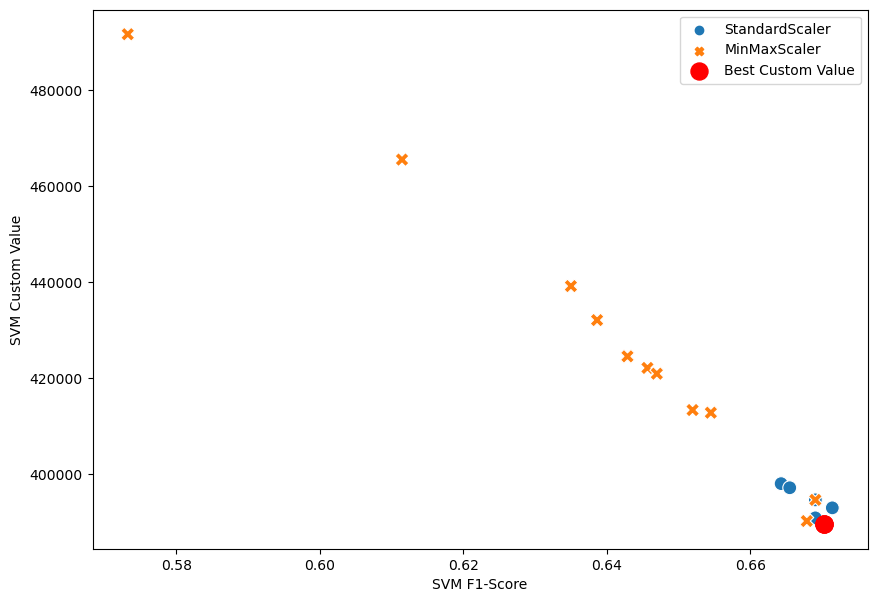

In [24]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='SVM F1-Score', y='SVM Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['SVM Custom Value'] == df_evaluation['SVM Custom Value'].min()]
plt.scatter(best_custom_value_row['SVM F1-Score'], best_custom_value_row['SVM Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"C: {best_custom_value_row['C'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()


Best Scaler Type: StandardScaler

Best hyperparameters:
C: 0.4

Best Set Accuracy: 0.9086
Best Set F1-Score: 0.6702
Best Set Precision: 0.7966
Best Set Recall: 0.5785
Best Set Custom Value: 389590.2900


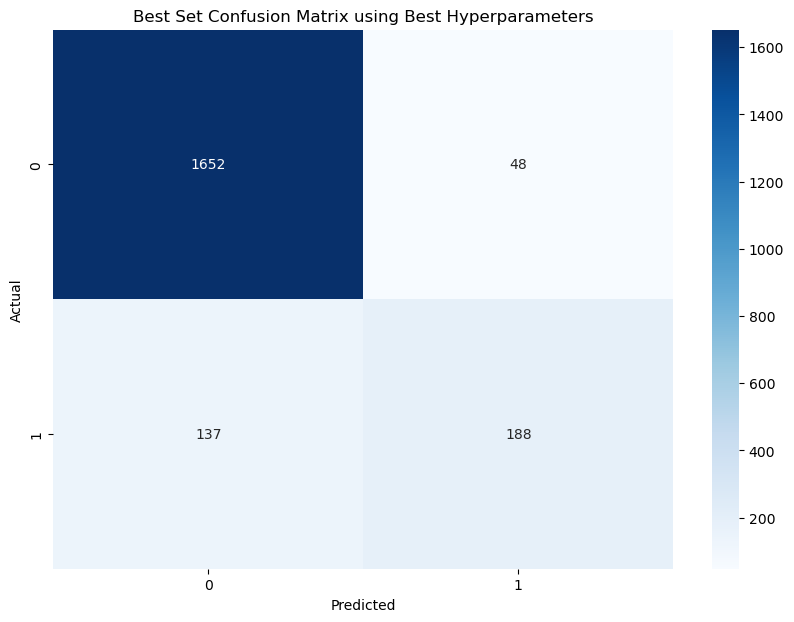

In [25]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_C = best_custom_value_row['C'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"C: {best_C}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_svm = SVC(C=best_C, kernel='linear', random_state=42)
best_svm.fit(X_train_scaled_best, y_train)

y_valid_pred = best_svm.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix using Best Hyperparameters')
plt.show()


Test Set Accuracy: 0.9112
Test Set F1-Score: 0.6907
Test Set Precision: 0.7852
Test Set Recall: 0.6166
Test Set Custom Value: 369969.8300


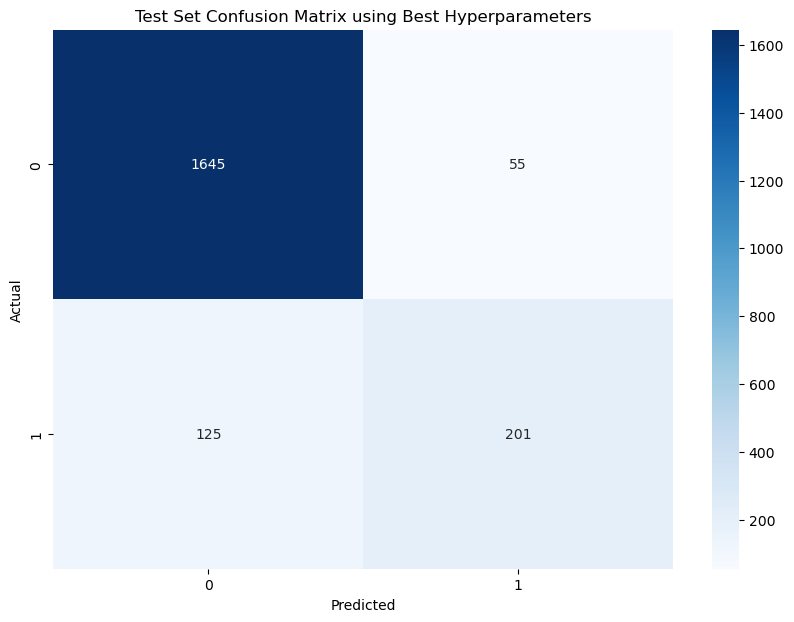

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [26]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_svm.predict(X_test_scaled)

# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()
# 비교를 위해 평가 추가
add_evaluation_metrics('SVM', test_acc, test_f1, test_precision, test_recall, test_custom_value)
print(model_evaluation)

# KNN

In [27]:
param_grid = {
    'n_neighbors': [1,2,3,4, 5,6, 7,8, 9,10, 11]
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for n_neighbors in param_grid['n_neighbors']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train_scaled, y_train)

        y_pred = knn.predict(X_valid_scaled)

        acc = accuracy_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        precision = precision_score(y_valid, y_pred)
        conf_matrix = confusion_matrix(y_valid, y_pred)
        recall = compute_recall(conf_matrix)

        evaluation_metrics.append({
            'Scaler Type': scaler_name,
            'n_neighbors': n_neighbors,
            'KNN Accuracy': acc,
            'KNN F1-Score': f1,
            'KNN Precision': precision,
            'KNN Recall': recall,
            'KNN Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
            'KNN Confusion Matrix': conf_matrix
        })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation

,Scaler Type,n_neighbors,KNN Accuracy,KNN F1-Score,KNN Precision,KNN Recall,KNN Custom Value,KNN Confusion Matrix
0,StandardScaler,1,0.840000,0.443299,0.501946,0.396923,599016.09,"[[1572, 128], [196, 129]]"
1,StandardScaler,2,0.860741,0.338028,0.712871,0.221538,602791.61,"[[1671, 29], [253, 72]]"
2,StandardScaler,3,0.872099,0.495127,0.675532,0.390769,541320.10,"[[1639, 61], [198, 127]]"
3,StandardScaler,4,0.871605,0.392523,0.815534,0.258462,576408.66,"[[1681, 19], [241, 84]]"
4,StandardScaler,5,0.872099,0.450106,0.726027,0.326154,559320.05,"[[1660, 40], [219, 106]]"
5,StandardScaler,6,0.869136,0.379391,0.794118,0.249231,586646.04,"[[1679, 21], [244, 81]]"
6,StandardScaler,7,0.875062,0.443956,0.776923,0.310769,559186.12,"[[1671, 29], [224, 101]]"
7,StandardScaler,8,0.867654,0.352657,0.820225,0.224615,597766.68,"[[1684, 16], [252, 73]]"
8,StandardScaler,9,0.873086,0.411899,0.803571,0.276923,579018.65,"[[1678, 22], [235, 90]]"
9,StandardScaler,10,0.867654,0.336634,0.860759,0.209231,605295.37,"[[1689, 11], [257, 68]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
n_neighbors: 3
------------------------------


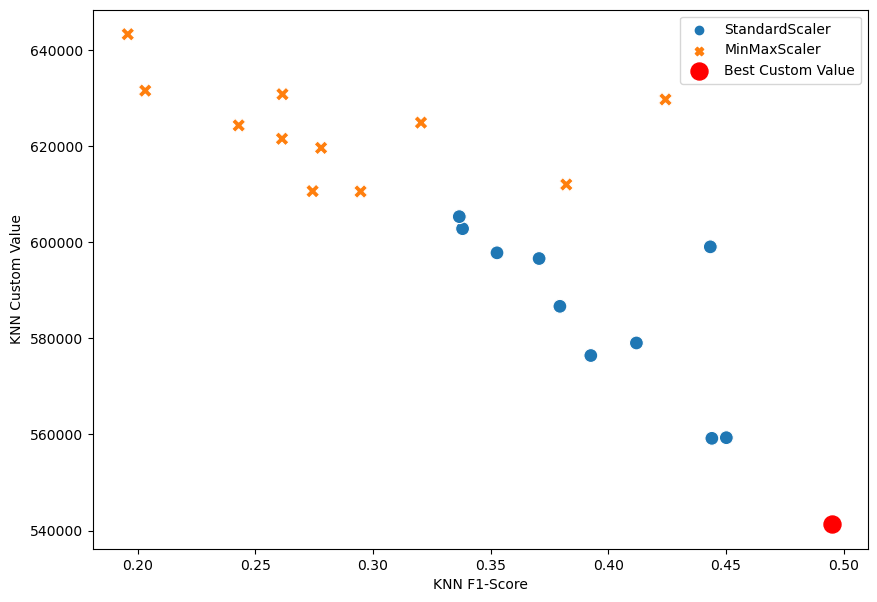

In [28]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='KNN F1-Score', y='KNN Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['KNN Custom Value'] == df_evaluation['KNN Custom Value'].min()]
plt.scatter(best_custom_value_row['KNN F1-Score'], best_custom_value_row['KNN Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"n_neighbors: {best_custom_value_row['n_neighbors'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()

Best Scaler Type: StandardScaler

Best hyperparameters:
n_neighbors: 3

Best Set Accuracy: 0.8721
Best Set F1-Score: 0.4951
Best Set Precision: 0.6755
Best Set Recall: 0.3908
Best Set Custom Value: 541320.1000


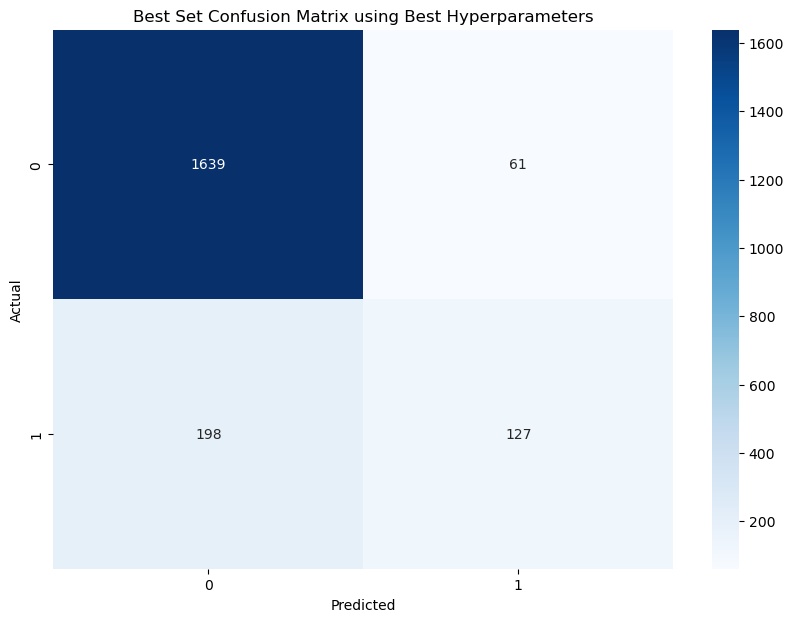

In [29]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_n_neighbors = best_custom_value_row['n_neighbors'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"n_neighbors: {best_n_neighbors}")

best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train_scaled_best, y_train)

y_valid_pred = best_knn.predict(X_valid_scaled)

valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix using Best Hyperparameters')
plt.show()


Test Set Accuracy: 0.8692
Test Set F1-Score: 0.4972
Test Set Precision: 0.6517
Test Set Recall: 0.4018
Test Set Custom Value: 530796.4700


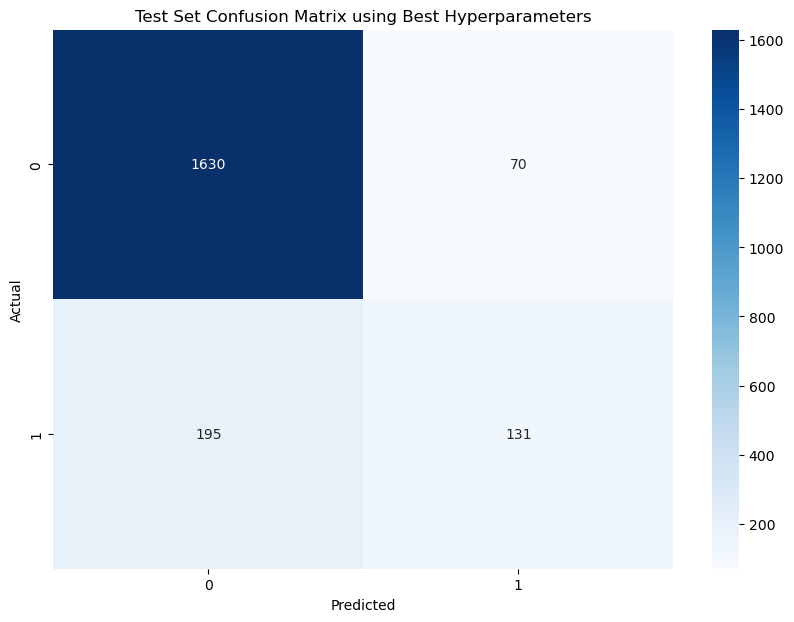

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83
5                 KNN  0.869200  0.497154   0.651741  0.401840     530796.47


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [30]:
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_test_scaled = best_scaler.transform(X_test)

best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train_scaled_best, y_train)

y_test_pred = best_knn.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

add_evaluation_metrics('KNN', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)


# Decision Tree

In [31]:

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
                dt.fit(X_train_scaled, y_train)

                y_pred = dt.predict(X_valid_scaled)

                acc = accuracy_score(y_valid, y_pred)
                f1 = f1_score(y_valid, y_pred)
                precision = precision_score(y_valid, y_pred)
                conf_matrix = confusion_matrix(y_valid, y_pred)
                recall = compute_recall(conf_matrix)

                evaluation_metrics.append({
                    'Scaler Type': scaler_name,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'DecisionTree Accuracy': acc,
                    'DecisionTree F1-Score': f1,
                    'DecisionTree Precision': precision,
                    'DecisionTree Recall': recall,
                    'DecisionTree Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                    'DecisionTree Confusion Matrix': conf_matrix
                })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation


,Scaler Type,max_depth,min_samples_split,min_samples_leaf,DecisionTree Accuracy,DecisionTree F1-Score,DecisionTree Precision,DecisionTree Recall,DecisionTree Custom Value,DecisionTree Confusion Matrix
0,StandardScaler,NaN,2,1,0.929877,0.780186,0.785047,0.775385,231062.30,"[[1631, 69], [73, 252]]"
1,StandardScaler,NaN,2,2,0.935309,0.793049,0.814935,0.772308,220833.41,"[[1643, 57], [74, 251]]"
2,StandardScaler,NaN,2,4,0.934321,0.788553,0.815789,0.763077,232042.80,"[[1644, 56], [77, 248]]"
3,StandardScaler,NaN,5,1,0.931358,0.785162,0.788820,0.781538,216554.12,"[[1632, 68], [71, 254]]"
4,StandardScaler,NaN,5,2,0.930370,0.779343,0.792994,0.766154,232680.00,"[[1635, 65], [76, 249]]"
...,...,...,...,...,...,...,...,...,...,...
67,MinMaxScaler,30.0,5,2,0.930370,0.779343,0.792994,0.766154,232680.00,"[[1635, 65], [76, 249]]"
68,MinMaxScaler,30.0,5,4,0.934321,0.788553,0.815789,0.763077,232042.80,"[[1644, 56], [77, 248]]"
69,MinMaxScaler,30.0,10,1,0.929383,0.778295,0.784375,0.772308,223099.38,"[[1631, 69], [74, 251]]"
70,MinMaxScaler,30.0,10,2,0.932840,0.786164,0.803859,0.769231,234672.60,"[[1639, 61], [75, 250]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
max_depth: 10.0
min_samples_split: 5
min_samples_leaf: 1
------------------------------


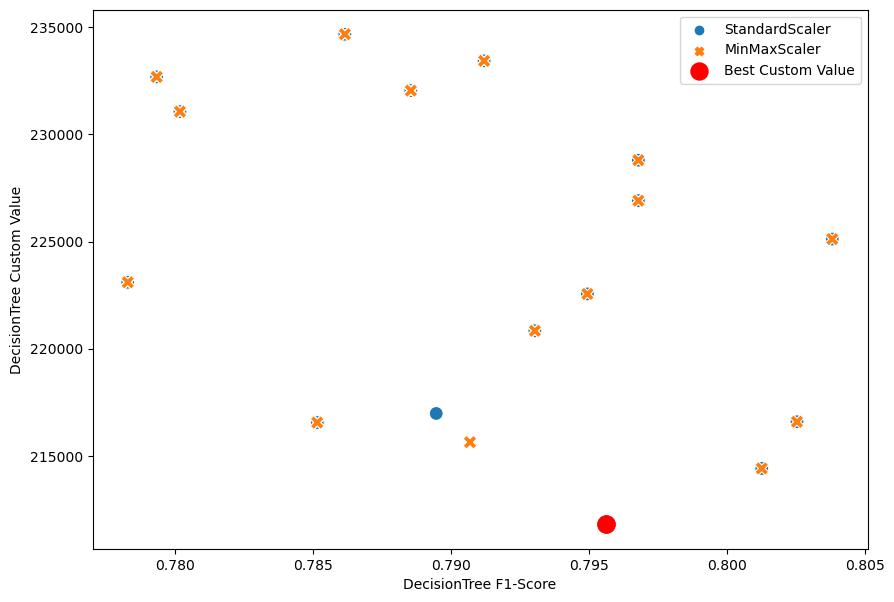

In [32]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='DecisionTree F1-Score', y='DecisionTree Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['DecisionTree Custom Value'] == df_evaluation['DecisionTree Custom Value'].min()]
plt.scatter(best_custom_value_row['DecisionTree F1-Score'], best_custom_value_row['DecisionTree Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"max_depth: {best_custom_value_row['max_depth'].iloc[0]}")
print(f"min_samples_split: {best_custom_value_row['min_samples_split'].iloc[0]}")
print(f"min_samples_leaf: {best_custom_value_row['min_samples_leaf'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()

Best Scaler Type: StandardScaler

Best hyperparameters:
max_depth: 10
min_samples_split: 5
min_samples_leaf: 1

Best Set Accuracy: 0.9353
Best Set F1-Score: 0.7956
Best Set Precision: 0.8070
Best Set Recall: 0.7846
Best Set Custom Value: 211809.2700


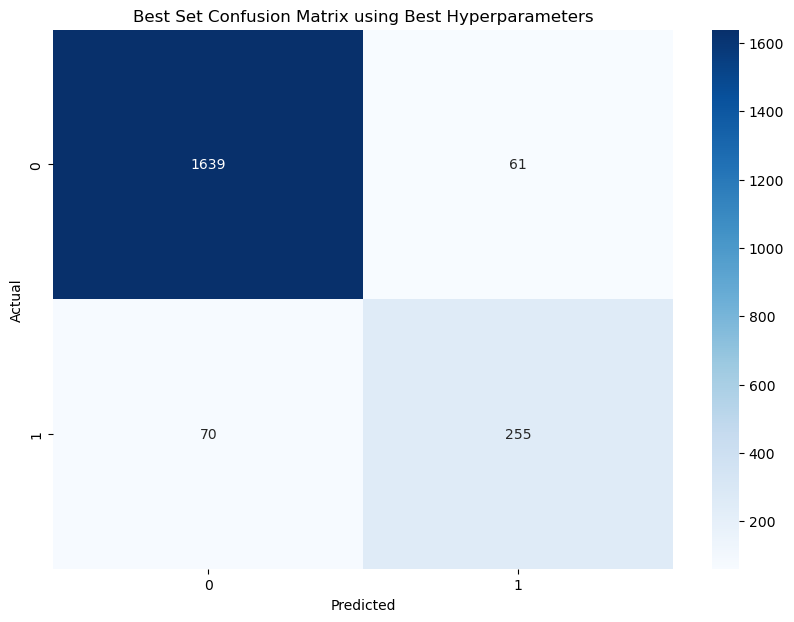

In [33]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_max_depth = best_custom_value_row['max_depth'].iloc[0]
best_min_samples_split = best_custom_value_row['min_samples_split'].iloc[0]
best_min_samples_leaf = best_custom_value_row['min_samples_leaf'].iloc[0]

best_max_depth = int(best_max_depth) if not pd.isna(best_max_depth) else None

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"max_depth: {best_max_depth}")
print(f"min_samples_split: {best_min_samples_split}")
print(f"min_samples_leaf: {best_min_samples_leaf}")

best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_dt.fit(X_train_scaled_best, y_train)

y_valid_pred = best_dt.predict(X_valid_scaled)

valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix using Best Hyperparameters')
plt.show()



Test Set Accuracy: 0.9457
Test Set F1-Score: 0.8297
Test Set Precision: 0.8375
Test Set Recall: 0.8221
Test Set Custom Value: 174101.7500


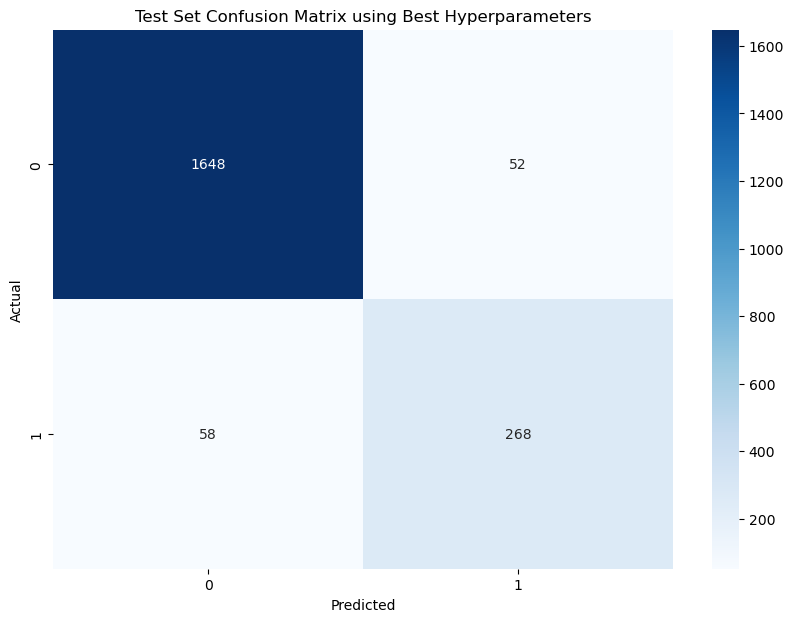

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83
5                 KNN  0.869200  0.497154   0.651741  0.401840     530796.47
6        DecisionTree  0.945706  0.829721   0.837500  0.822086     174101.75


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [34]:
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_test_scaled = best_scaler.transform(X_test)

best_dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_dt.fit(X_train_scaled_best, y_train)

y_test_pred = best_dt.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

add_evaluation_metrics('DecisionTree', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)


# RandomForest

In [35]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}

evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
                rf.fit(X_train_scaled, y_train)

                y_pred = rf.predict(X_valid_scaled)

                acc = accuracy_score(y_valid, y_pred)
                f1 = f1_score(y_valid, y_pred)
                precision = precision_score(y_valid, y_pred)
                conf_matrix = confusion_matrix(y_valid, y_pred)
                recall = compute_recall(conf_matrix)

                evaluation_metrics.append({
                    'Scaler Type': scaler_name,
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'RandomForest Accuracy': acc,
                    'RandomForest F1-Score': f1,
                    'RandomForest Precision': precision,
                    'RandomForest Recall': recall,
                    'RandomForest Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                    'RandomForest Confusion Matrix': conf_matrix
                })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation

,Scaler Type,n_estimators,max_depth,min_samples_split,RandomForest Accuracy,RandomForest F1-Score,RandomForest Precision,RandomForest Recall,RandomForest Custom Value,RandomForest Confusion Matrix
0,StandardScaler,50,NaN,2,0.947654,0.817241,0.929412,0.729231,228996.24,"[[1682, 18], [88, 237]]"
1,StandardScaler,50,NaN,5,0.946173,0.813675,0.915385,0.732308,234352.36,"[[1678, 22], [87, 238]]"
2,StandardScaler,50,NaN,10,0.950123,0.827350,0.930769,0.744615,209661.38,"[[1682, 18], [83, 242]]"
3,StandardScaler,50,10.0,2,0.944198,0.803478,0.924000,0.710769,256325.65,"[[1681, 19], [94, 231]]"
4,StandardScaler,50,10.0,5,0.942716,0.797909,0.919679,0.704615,266344.74,"[[1680, 20], [96, 229]]"
...,...,...,...,...,...,...,...,...,...,...
67,MinMaxScaler,200,20.0,5,0.952593,0.837838,0.928839,0.763077,213953.05,"[[1681, 19], [77, 248]]"
68,MinMaxScaler,200,20.0,10,0.951605,0.833898,0.928302,0.756923,229814.91,"[[1681, 19], [79, 246]]"
69,MinMaxScaler,200,30.0,2,0.953086,0.840336,0.925926,0.769231,210906.03,"[[1680, 20], [75, 250]]"
70,MinMaxScaler,200,30.0,5,0.952593,0.837838,0.928839,0.763077,214125.24,"[[1681, 19], [77, 248]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
n_estimators: 200
max_depth: nan
min_samples_split: 2
------------------------------


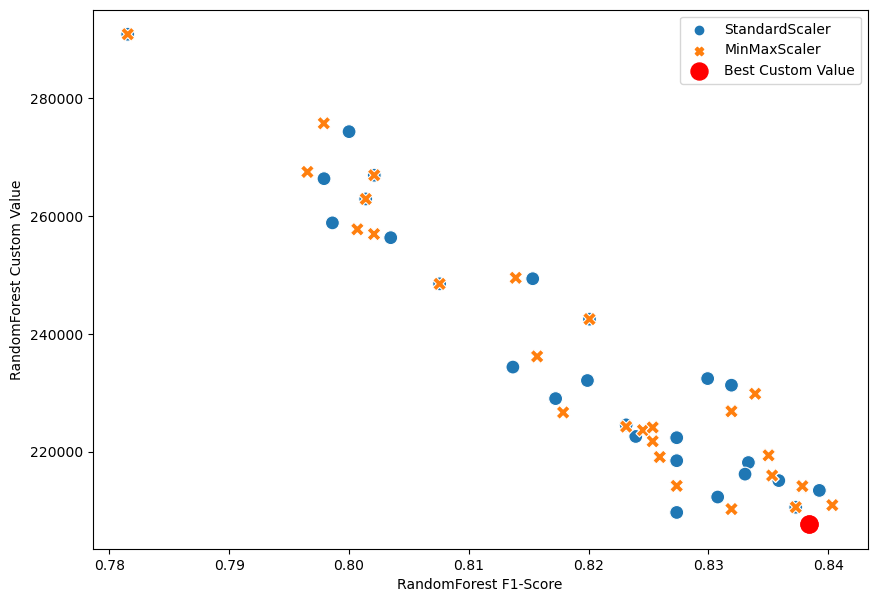

In [36]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='RandomForest F1-Score', y='RandomForest Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

# Best Custom Value의 row를 찾습니다.
best_custom_value_row = df_evaluation[df_evaluation['RandomForest Custom Value'] == df_evaluation['RandomForest Custom Value'].min()]

# Best Custom Value의 점을 빨간색으로 표시
plt.scatter(best_custom_value_row['RandomForest F1-Score'], best_custom_value_row['RandomForest Custom Value'], color='red', s=150, label='Best Custom Value')

# Best Custom Value의 하이퍼파라미터 출력
print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"n_estimators: {best_custom_value_row['n_estimators'].iloc[0]}")
print(f"max_depth: {best_custom_value_row['max_depth'].iloc[0]}")
print(f"min_samples_split: {best_custom_value_row['min_samples_split'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()


Best Scaler Type: StandardScaler

Best hyperparameters:
n_estimators: 200
max_depth: nan
min_samples_split: 2

Best Accuracy: 0.9526
Best F1-Score: 0.8384
Best Precision: 0.9257
Best Recall: 0.7662
Best Custom Value: 207663.9000


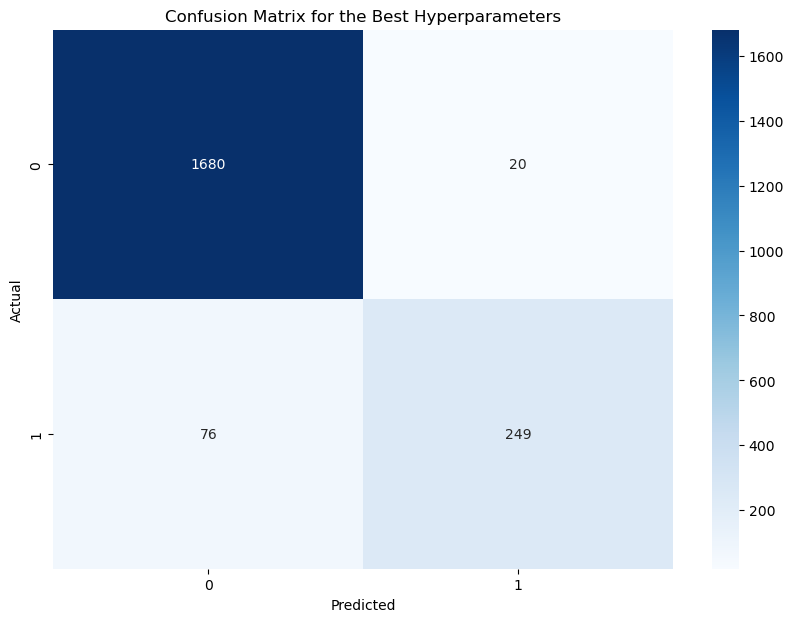

In [37]:
best_confusion_matrix = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'RandomForest Confusion Matrix']

best_accuracy = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'RandomForest Accuracy']
best_f1score = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'RandomForest F1-Score']
best_precision = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'RandomForest Precision']
best_recall = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'RandomForest Recall']
best_custom_value = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'RandomForest Custom Value']
best_scaler_type = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'Scaler Type']
best_n_estimators = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'n_estimators']
best_max_depth = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'max_depth']
best_min_samples_split = df_evaluation.loc[df_evaluation['RandomForest Custom Value'].idxmin(), 'min_samples_split']

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"n_estimators: {best_n_estimators}")
print(f"max_depth: {best_max_depth}")
print(f"min_samples_split: {best_min_samples_split}")

print(f"\nBest Accuracy: {best_accuracy:.4f}")
print(f"Best F1-Score: {best_f1score:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")
print(f"Best Custom Value: {best_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(best_confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Best Hyperparameters')
plt.show()



Test Set Accuracy: 0.9566
Test Set F1-Score: 0.8557
Test Set Precision: 0.9190
Test Set Recall: 0.8006
Test Set Custom Value: 204410.0100


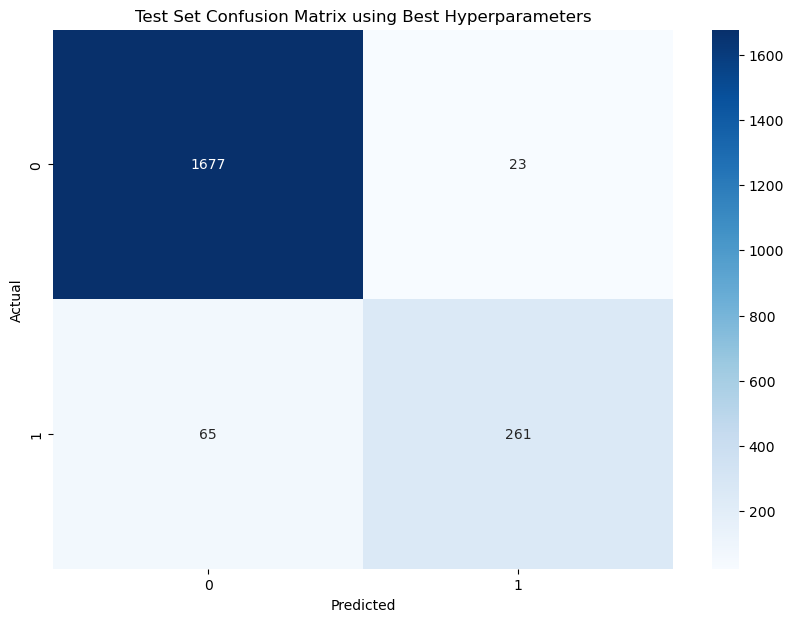

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83
5                 KNN  0.869200  0.497154   0.651741  0.401840     530796.47
6        DecisionTree  0.945706  0.829721   0.837500  0.822086     174101.75
7        RandomForest  0.956565  0.855738   0.919014  0.800613     204410.01


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [38]:

scaler = scalers[best_scaler_type]
X_train_scaled_best = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_max_depth = int(best_max_depth) if not pd.isna(best_max_depth) else None

best_rf = RandomForestClassifier(n_estimators=best_n_estimators,
                                 max_depth=best_max_depth,
                                 min_samples_split=best_min_samples_split,
                                 random_state=42)
best_rf.fit(X_train_scaled_best, y_train)
y_test_pred = best_rf.predict(X_test_scaled)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

add_evaluation_metrics('RandomForest', test_acc, test_f1, test_precision, test_recall, test_custom_value)
print(model_evaluation)

# XGBoost

In [39]:
# XGBoost
param_grid = {
    'learning_rate': [0.02, 0.05, 0.07],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 5, 10],
    'gamma': [0, 0.1, 0.2]
}

scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                for gamma in param_grid['gamma']:
                    model = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, gamma=gamma, random_state=42)
                    model.fit(X_train_scaled, y_train)

                    y_pred = model.predict(X_valid_scaled)

                    acc = accuracy_score(y_valid, y_pred)
                    f1 = f1_score(y_valid, y_pred)
                    precision = precision_score(y_valid, y_pred)
                    conf_matrix = confusion_matrix(y_valid, y_pred)
                    recall = compute_recall(conf_matrix)

                    evaluation_metrics.append({
                        'Scaler Type': scaler_name,
                        'learning_rate': learning_rate,
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'gamma': gamma,
                        'XGBoost Accuracy': acc,
                        'XGBoost F1-Score': f1,
                        'XGBoost Precision': precision,
                        'XGBoost Recall': recall,
                        'XGBoost Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                        'XGBoost Confusion Matrix': conf_matrix
                    })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation


,Scaler Type,learning_rate,n_estimators,max_depth,gamma,XGBoost Accuracy,XGBoost F1-Score,XGBoost Precision,XGBoost Recall,XGBoost Custom Value,XGBoost Confusion Matrix
0,StandardScaler,0.02,50,2,0.0,0.910123,0.641732,0.890710,0.501538,450853.66,"[[1680, 20], [162, 163]]"
1,StandardScaler,0.02,50,2,0.1,0.910123,0.641732,0.890710,0.501538,450853.66,"[[1680, 20], [162, 163]]"
2,StandardScaler,0.02,50,2,0.2,0.910123,0.641732,0.890710,0.501538,450853.66,"[[1680, 20], [162, 163]]"
3,StandardScaler,0.02,50,5,0.0,0.944691,0.818770,0.863481,0.778462,169023.33,"[[1660, 40], [72, 253]]"
4,StandardScaler,0.02,50,5,0.1,0.944691,0.818770,0.863481,0.778462,169023.33,"[[1660, 40], [72, 253]]"
...,...,...,...,...,...,...,...,...,...,...,...
157,MinMaxScaler,0.07,150,5,0.1,0.963457,0.881410,0.919732,0.846154,120866.41,"[[1676, 24], [50, 275]]"
158,MinMaxScaler,0.07,150,5,0.2,0.963951,0.883200,0.920000,0.849231,119278.51,"[[1676, 24], [49, 276]]"
159,MinMaxScaler,0.07,150,10,0.0,0.960494,0.873418,0.899023,0.849231,125092.28,"[[1669, 31], [49, 276]]"
160,MinMaxScaler,0.07,150,10,0.1,0.960494,0.873418,0.899023,0.849231,125229.56,"[[1669, 31], [49, 276]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
learning_rate: 0.07
n_estimators: 150
max_depth: 5
gamma: 0.0
------------------------------


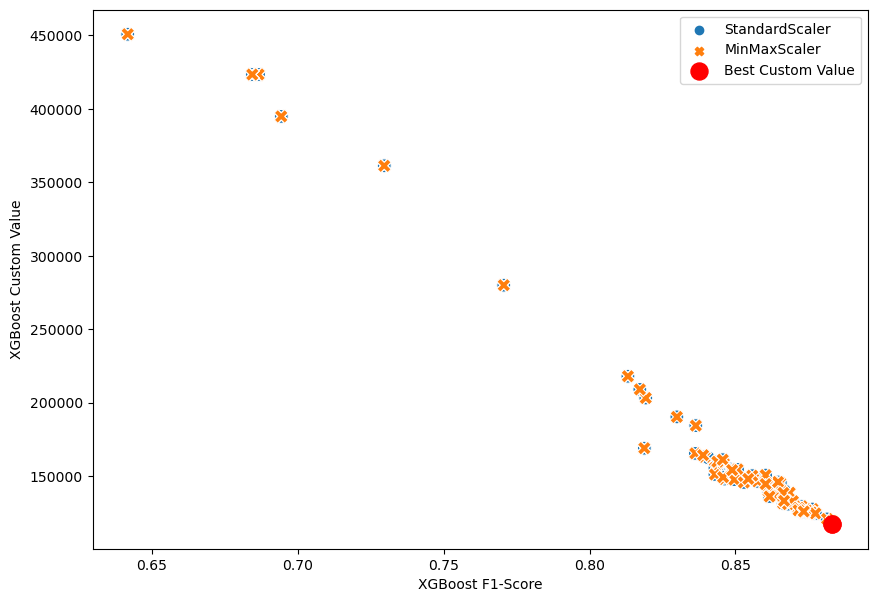

In [40]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='XGBoost F1-Score', y='XGBoost Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['XGBoost Custom Value'] == df_evaluation['XGBoost Custom Value'].min()]
plt.scatter(best_custom_value_row['XGBoost F1-Score'], best_custom_value_row['XGBoost Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"learning_rate: {best_custom_value_row['learning_rate'].iloc[0]}")
print(f"n_estimators: {best_custom_value_row['n_estimators'].iloc[0]}")
print(f"max_depth: {best_custom_value_row['max_depth'].iloc[0]}")
print(f"gamma: {best_custom_value_row['gamma'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()


Best Scaler Type: StandardScaler

Best hyperparameters:
learning_rate: 0.07
n_estimators: 150
max_depth: 5
gamma: 0.0

Best Set Accuracy: 0.9640
Best Set F1-Score: 0.8832
Best Set Precision: 0.9200
Best Set Recall: 0.8492
Best Set Custom Value: 117267.1700


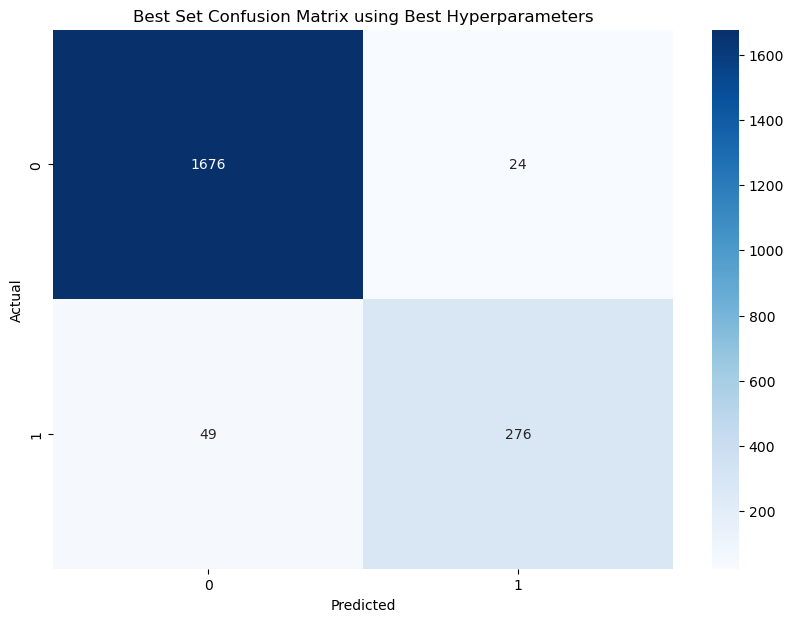

In [41]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_learning_rate = best_custom_value_row['learning_rate'].iloc[0]
best_n_estimators = best_custom_value_row['n_estimators'].iloc[0]
best_max_depth = best_custom_value_row['max_depth'].iloc[0]
best_gamma = best_custom_value_row['gamma'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"learning_rate: {best_learning_rate}")
print(f"n_estimators: {best_n_estimators}")
print(f"max_depth: {best_max_depth}")
print(f"gamma: {best_gamma}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_xgb = xgb.XGBClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, max_depth=best_max_depth, gamma=best_gamma, random_state=42)
best_xgb.fit(X_train_scaled_best, y_train)

y_valid_pred = best_xgb.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix using Best Hyperparameters')
plt.show()



Test Set Accuracy: 0.9738
Test Set F1-Score: 0.9178
Test Set Precision: 0.9279
Test Set Recall: 0.9080
Test Set Custom Value: 87092.5800


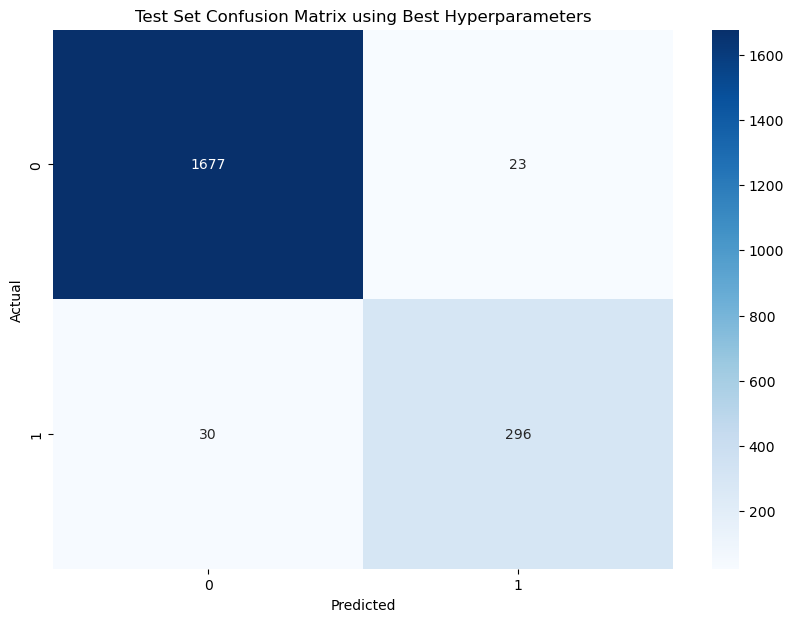

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83
5                 KNN  0.869200  0.497154   0.651741  0.401840     530796.47
6        DecisionTree  0.945706  0.829721   0.837500  0.822086     174101.75
7        RandomForest  0.956565  0.855738   0.919014  0.800613     204410.01
8             XGBoost  0.973840  0.917829   0.927900  0.907975      87092.58


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [42]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_xgb.predict(X_test_scaled)
# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

# 비교를 위해 평가 추가
add_evaluation_metrics('XGBoost', test_acc, test_f1, test_precision, test_recall, test_custom_value)
print(model_evaluation)

# LGBM_FeedBack

In [43]:
# LGBM
param_grid = {
    'learning_rate': [0.05, 0.07, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [7, 14, 31],
    'min_data_in_leaf': [20, 50, 100]
}
scalers = {'StandardScaler': StandardScaler(), 'MinMaxScaler': MinMaxScaler()}
evaluation_metrics = []

for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    for learning_rate in param_grid['learning_rate']:
        for n_estimators in param_grid['n_estimators']:
            for max_depth in param_grid['max_depth']:
                for num_leaves in param_grid['num_leaves']:
                    for min_data_in_leaf in param_grid['min_data_in_leaf']:
                        model = lgb.LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves, min_child_samples=min_data_in_leaf, random_state=42,verbosity=-1)
                        model.fit(X_train_scaled, y_train)

                        y_pred = model.predict(X_valid_scaled)

                        acc = accuracy_score(y_valid, y_pred)
                        f1 = f1_score(y_valid, y_pred)
                        precision = precision_score(y_valid, y_pred)
                        conf_matrix = confusion_matrix(y_valid, y_pred)
                        recall = compute_recall(conf_matrix)

                        evaluation_metrics.append({
                            'Scaler Type': scaler_name,
                            'learning_rate': learning_rate,
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'num_leaves': num_leaves,
                            'min_data_in_leaf': min_data_in_leaf,
                            'LGBM Accuracy': acc,
                            'LGBM F1-Score': f1,
                            'LGBM Precision': precision,
                            'LGBM Recall': recall,
                            'LGBM Custom Value': compute_custom_value(y_valid, y_pred, X_valid),
                            'LGBM Confusion Matrix': conf_matrix
                        })

df_evaluation = pd.DataFrame(evaluation_metrics)
df_evaluation

,Scaler Type,learning_rate,n_estimators,max_depth,num_leaves,min_data_in_leaf,LGBM Accuracy,LGBM F1-Score,LGBM Precision,LGBM Recall,LGBM Custom Value,LGBM Confusion Matrix
0,StandardScaler,0.05,50,3,7,20,0.944691,0.804196,0.931174,0.707692,220213.93,"[[1683, 17], [95, 230]]"
1,StandardScaler,0.05,50,3,7,50,0.944691,0.804878,0.927711,0.710769,225717.32,"[[1682, 18], [94, 231]]"
2,StandardScaler,0.05,50,3,7,100,0.945679,0.807692,0.935223,0.710769,212534.69,"[[1684, 16], [94, 231]]"
3,StandardScaler,0.05,50,3,14,20,0.943704,0.800000,0.930612,0.701538,225213.39,"[[1683, 17], [97, 228]]"
4,StandardScaler,0.05,50,3,14,50,0.944198,0.802102,0.930894,0.704615,225664.10,"[[1683, 17], [96, 229]]"
...,...,...,...,...,...,...,...,...,...,...,...,...
481,MinMaxScaler,0.10,200,7,14,50,0.966914,0.893142,0.927152,0.861538,103062.82,"[[1678, 22], [45, 280]]"
482,MinMaxScaler,0.10,200,7,14,100,0.967901,0.896332,0.930464,0.864615,100095.76,"[[1679, 21], [44, 281]]"
483,MinMaxScaler,0.10,200,7,31,20,0.964444,0.886435,0.909385,0.864615,111771.28,"[[1672, 28], [44, 281]]"
484,MinMaxScaler,0.10,200,7,31,50,0.965926,0.889952,0.923841,0.858462,102213.01,"[[1677, 23], [46, 279]]"


Best Custom Value Hyperparameters:
Scaler: StandardScaler
learning_rate: 0.1
n_estimators: 200
max_depth: 7
num_leaves: 14
min_data_in_leaf: 20
------------------------------


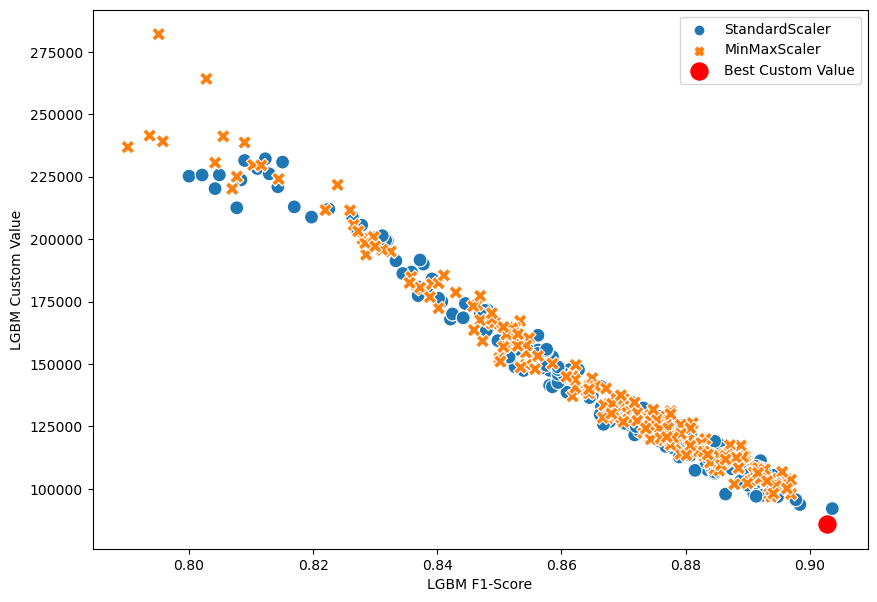

In [44]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_evaluation, x='LGBM F1-Score', y='LGBM Custom Value', hue='Scaler Type', style='Scaler Type', s=100)

best_custom_value_row = df_evaluation[df_evaluation['LGBM Custom Value'] == df_evaluation['LGBM Custom Value'].min()]
plt.scatter(best_custom_value_row['LGBM F1-Score'], best_custom_value_row['LGBM Custom Value'], color='red', s=150, label='Best Custom Value')

print("Best Custom Value Hyperparameters:")
print(f"Scaler: {best_custom_value_row['Scaler Type'].iloc[0]}")
print(f"learning_rate: {best_custom_value_row['learning_rate'].iloc[0]}")
print(f"n_estimators: {best_custom_value_row['n_estimators'].iloc[0]}")
print(f"max_depth: {best_custom_value_row['max_depth'].iloc[0]}")
print(f"num_leaves: {best_custom_value_row['num_leaves'].iloc[0]}")
print(f"min_data_in_leaf: {best_custom_value_row['min_data_in_leaf'].iloc[0]}")
print("------------------------------")

plt.legend()
plt.show()


Best Scaler Type: StandardScaler

Best hyperparameters:
learning_rate: 0.1
n_estimators: 200
max_depth: 7
num_leaves: 14
min_data_in_leaf: 20

Best Set Accuracy: 0.9694
Best Set F1-Score: 0.9028
Best Set Precision: 0.9201
Best Set Recall: 0.8862
Best Set Custom Value: 85816.9400


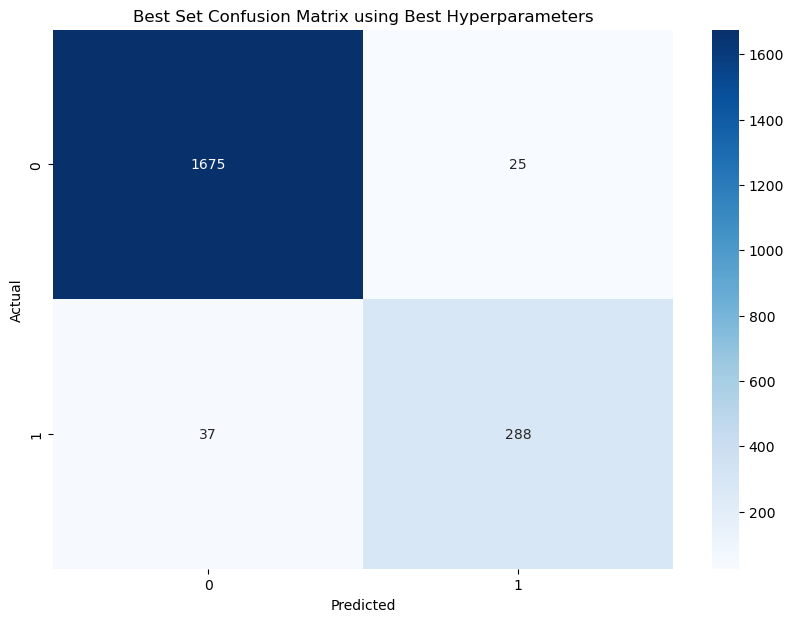

In [45]:
best_scaler_type = best_custom_value_row['Scaler Type'].iloc[0]
best_learning_rate = best_custom_value_row['learning_rate'].iloc[0]
best_n_estimators = best_custom_value_row['n_estimators'].iloc[0]
best_max_depth = best_custom_value_row['max_depth'].iloc[0]
best_num_leaves = best_custom_value_row['num_leaves'].iloc[0]
best_min_data_in_leaf = best_custom_value_row['min_data_in_leaf'].iloc[0]

print("Best Scaler Type:", best_scaler_type)
print("\nBest hyperparameters:")
print(f"learning_rate: {best_learning_rate}")
print(f"n_estimators: {best_n_estimators}")
print(f"max_depth: {best_max_depth}")
print(f"num_leaves: {best_num_leaves}")
print(f"min_data_in_leaf: {best_min_data_in_leaf}")
# best hyper parameter 적용
best_scaler = scalers[best_scaler_type]
X_train_scaled_best = best_scaler.fit_transform(X_train)
X_valid_scaled = best_scaler.transform(X_valid)

best_lgbm = lgb.LGBMClassifier(learning_rate=best_learning_rate, n_estimators=best_n_estimators, max_depth=best_max_depth, num_leaves=best_num_leaves, min_child_samples=best_min_data_in_leaf, random_state=42,verbosity=-1)
best_lgbm.fit(X_train_scaled_best, y_train)

y_valid_pred = best_lgbm.predict(X_valid_scaled)
# validation set에서 결과 확인
valid_acc = accuracy_score(y_valid, y_valid_pred)
valid_f1 = f1_score(y_valid, y_valid_pred)
valid_precision = precision_score(y_valid, y_valid_pred)
valid_conf_matrix = confusion_matrix(y_valid, y_valid_pred)
valid_recall = compute_recall(valid_conf_matrix)
valid_custom_value = compute_custom_value(y_valid, y_valid_pred, X_valid)

print(f"\nBest Set Accuracy: {valid_acc:.4f}")
print(f"Best Set F1-Score: {valid_f1:.4f}")
print(f"Best Set Precision: {valid_precision:.4f}")
print(f"Best Set Recall: {valid_recall:.4f}")
print(f"Best Set Custom Value: {valid_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(valid_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Best Set Confusion Matrix using Best Hyperparameters')
plt.show()



Test Set Accuracy: 0.9788
Test Set F1-Score: 0.9339
Test Set Precision: 0.9354
Test Set Recall: 0.9325
Test Set Custom Value: 66446.0200


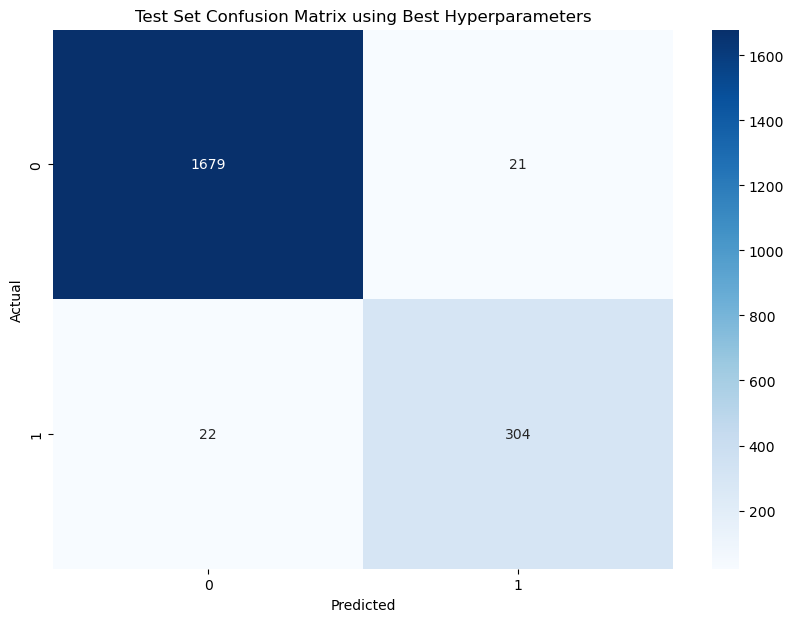

                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83
5                 KNN  0.869200  0.497154   0.651741  0.401840     530796.47
6        DecisionTree  0.945706  0.829721   0.837500  0.822086     174101.75
7        RandomForest  0.956565  0.855738   0.919014  0.800613     204410.01
8             XGBoost  0.973840  0.917829   0.927900  0.907975      87092.58
9       LGBM_Feedback  0.978776  0.933948   0.935385  0.932515      66446.02


/var/folders/fs/zfypqyv96hs22x794hfx0ycm0000gn/T/ipykernel_7827/4259987358.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_evaluation = model_evaluation.append({'Model': model_name,


In [46]:
# test set에 적용
X_test_scaled = best_scaler.transform(X_test)
y_test_pred = best_lgbm.predict(X_test_scaled)

# test set 결과 확인
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
test_recall = compute_recall(test_conf_matrix)
test_custom_value = compute_custom_value(y_test, y_test_pred, X_test)

print(f"\nTest Set Accuracy: {test_acc:.4f}")
print(f"Test Set F1-Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")
print(f"Test Set Custom Value: {test_custom_value:.4f}")

plt.figure(figsize=(10, 7))
sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix using Best Hyperparameters')
plt.show()

# 비교를 위해 평가 추가
add_evaluation_metrics('LGBM_Feedback', test_acc, test_f1, test_precision, test_recall, test_custom_value)

print(model_evaluation)


# 마무리

In [47]:
print(model_evaluation)


                Model  Accuracy  F1-Score  Precision    Recall  Custom Value
0  LogisticClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
1     LassoClassifier  0.911155  0.697987   0.770370  0.638037     359026.31
2  LogisticClassifier  0.911649  0.699160   0.773234  0.638037     358539.23
3  ElasticNetLogistic  0.910661  0.693739   0.773585  0.628834     367103.11
4                 SVM  0.911155  0.690722   0.785156  0.616564     369969.83
5                 KNN  0.869200  0.497154   0.651741  0.401840     530796.47
6        DecisionTree  0.945706  0.829721   0.837500  0.822086     174101.75
7        RandomForest  0.956565  0.855738   0.919014  0.800613     204410.01
8             XGBoost  0.973840  0.917829   0.927900  0.907975      87092.58
9       LGBM_Feedback  0.978776  0.933948   0.935385  0.932515      66446.02
